## Transfer Learning with TensorFlow (Feature Extraction) - Part 1

In [9]:
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [10]:
for dirpath, dirnames, filenames in os.walk("image_data/10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'image_data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'image_data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 

In [11]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();     

In [12]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "image_data/10_food_classes_10_percent/train/"
test_dir = "image_data/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/ 255.)
test_datagen = ImageDataGenerator(rescale = 1/ 255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical")

test_data = train_datagen.flow_from_directory(test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [13]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
    )
    
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tensorboard_callback

In [14]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
def create_model(model_url, num_classes = 10):
    feature_extractor_layer = hub.KerasLayer(model_url, trainable = False, name = 'feature_extraction_layer', 
        input_shape = IMAGE_SHAPE + (3,))
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')      
    ])
        
    return model

In [17]:
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

resnet_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'])

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [18]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs = 5, steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data, validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", experiment_name = "resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230928-000136
Epoch 1/5
24/24 [==============================] - 152s 6s/step - loss: 1.9877 - accuracy: 0.3453 - val_loss: 1.1852 - val_accuracy: 0.6452
Epoch 2/5
24/24 [==============================] - 156s 7s/step - loss: 0.9114 - accuracy: 0.7253 - val_loss: 0.8605 - val_accuracy: 0.7216
Epoch 3/5
24/24 [==============================] - 166s 7s/step - loss: 0.6429 - accuracy: 0.8107 - val_loss: 0.7374 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 159s 7s/step - loss: 0.4854 - accuracy: 0.8693 - val_loss: 0.7206 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 148s 6s/step - loss: 0.3960 - accuracy: 0.9013 - val_loss: 0.6603 - val_accuracy: 0.7856


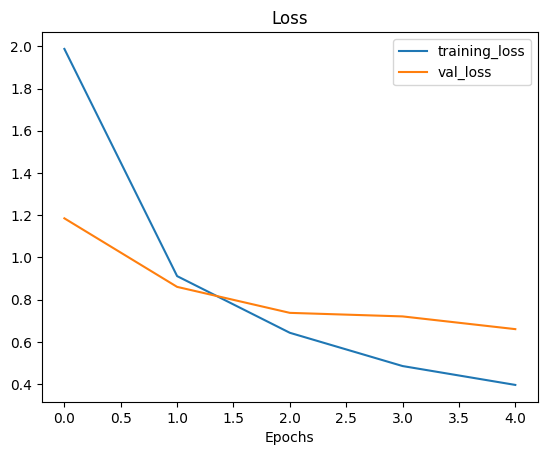

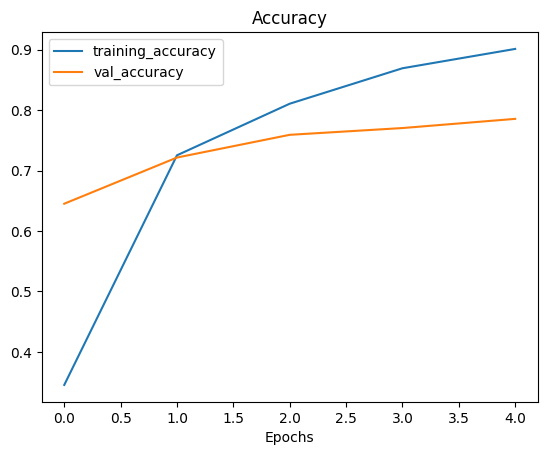

In [19]:
plot_loss_curves(resnet_history)

In [21]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [22]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
    epochs = 5, steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data, validation_steps = len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub", experiment_name = "efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230928-004643
Epoch 1/5
24/24 [==============================] - 106s 4s/step - loss: 1.8504 - accuracy: 0.4120 - val_loss: 1.2786 - val_accuracy: 0.7604
Epoch 2/5
24/24 [==============================] - 89s 4s/step - loss: 1.0466 - accuracy: 0.7880 - val_loss: 0.8537 - val_accuracy: 0.8384
Epoch 3/5
24/24 [==============================] - 92s 4s/step - loss: 0.7464 - accuracy: 0.8320 - val_loss: 0.6846 - val_accuracy: 0.8556
Epoch 4/5
24/24 [==============================] - 93s 4s/step - loss: 0.5981 - accuracy: 0.8733 - val_loss: 0.6001 - val_accuracy: 0.8652
Epoch 5/5
24/24 [==============================] - 93s 4s/step - loss: 0.5033 - accuracy: 0.8840 - val_loss: 0.5482 - val_accuracy: 0.8724


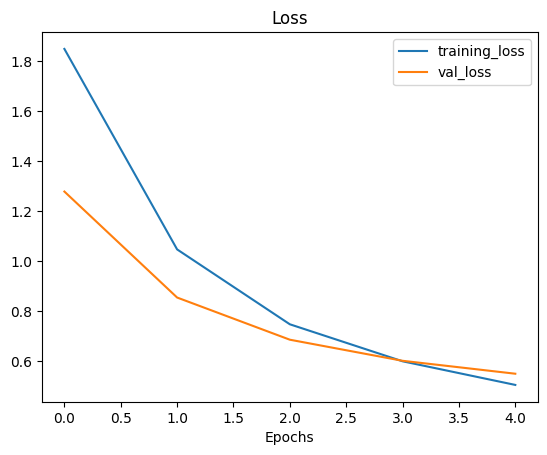

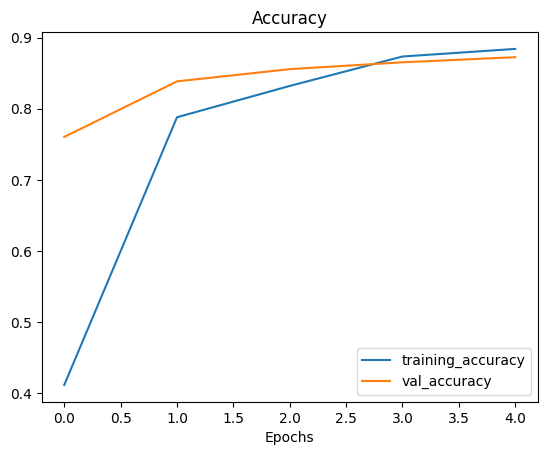

In [23]:
plot_loss_curves(efficientnet_history)

In [ ]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
#   --one_shot

In [ ]:
# !tensorboard dev list

In [ ]:
# !tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA